# Modify the file in a way that we do not use pandas series and arrays but dataframes!

https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

## One-Step univariate time series forecast

In [85]:
# univariate data preparation
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

import pandas as pd
import numpy as np
import myLibrary as mL
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from matplotlib import pyplot
from IPython.core.display_functions import display
import matplotlib.pyplot as plt

In [2]:
STATION_ID = "42036"    # 33.61% NaN values -> Best value for GOM and 2022
YEAR = "2022"
n=1
lag=1
num_test_records=7*24

In [3]:
data = mL.get_buoy_data(STATION_ID, YEAR)

data = data.drop([
    "WDIR_42036",
    "WSPD_42036",
    "WVHT_42036",
    "APD_42036",
    "MWD_42036",
    "PRES_42036",
    "ATMP_42036",
    #"WTMP_42036",
    "DEWP_42036"], axis=1)

from disc


In [4]:
print("NaN values: ", data.isna().sum().sum())
data.fillna(method='ffill', inplace=True) #ffill .. forward fill (just copy previous value)
print("Remaining NaN values: ", data.isna().sum().sum())
# msno.matrix(data)

NaN values:  57
Remaining NaN values:  0


In [5]:
print(type(data))
data

<class 'pandas.core.frame.DataFrame'>


,WTMP_42036
timestamp,
2022-01-01 00:00:00,23.0
2022-01-01 01:00:00,23.0
2022-01-01 02:00:00,23.0
2022-01-01 03:00:00,23.0
2022-01-01 04:00:00,23.0
...,...
2022-12-31 19:00:00,22.0
2022-12-31 20:00:00,22.0
2022-12-31 21:00:00,22.1


# Prepare data for LSTM network

* ### Transform Time Series to Stationary
    Preprocessing step that converts the absolute values to delta values. This should result in a more skillful forecast.
* ### Provide input X and output y.
    LSTM model expects data divided into input (X) and output (y). The model learns a function that maps an input X to an output y. In this example, X is the observation at timestep t-lag and y is the value at t.
* ### Split into train and test data
    use the last n records for testing


In [6]:
#Parameter: Dataframe, ..
#This function prepares the provided data for the LSTM network.
# * differenciates the data
# * creates an input column X and an output column y
# * devides the data into train and test data.
#returns a df with train and a df with test data
#Limitation: Currently only for single WTMP_ feature!
def data_to_supervised(df, n=1, lag=1, num_test_records=7*24):
    supervised = pd.DataFrame()

    #Transform time series to stationary. = Preprocessing step that converts the absolute values to delta values.
    supervised["X"] =  df[f"WTMP_{STATION_ID}"] - df[f"WTMP_{STATION_ID}"].shift(n)    # y = value(i) - value(i-n)
    supervised = supervised.iloc[n:] # remove first n entries since there is no delta value for them

    #LSTM model expects data devided into input (X) and output (y). The model learns a function that maps an input X to an output y. In this example, X is the observation at timestep t-1 and y is the value at t.
    supervised["y"] = supervised['X'].shift(lag)
    #supervised["y"] = supervised["y"].fillna(0) # first n entries are NaN
    supervised = supervised.iloc[lag:] # remove first lag entries since there is no valid value in y

    train, test = supervised[0:-num_test_records], supervised[-num_test_records:]

    return train, test


train, test = data_to_supervised(data, n=n, lag=lag, num_test_records=num_test_records)
train

,X,y
timestamp,,
2022-01-01 02:00:00,0.0,0.0
2022-01-01 03:00:00,0.0,0.0
2022-01-01 04:00:00,0.0,0.0
2022-01-01 05:00:00,0.0,0.0
2022-01-01 06:00:00,-0.1,0.0
...,...,...
2022-12-24 19:00:00,0.0,-0.1
2022-12-24 20:00:00,0.1,0.0
2022-12-24 21:00:00,-0.1,0.1


In [7]:
test

,X,y
timestamp,,
2022-12-25 00:00:00,0.1,-0.1
2022-12-25 01:00:00,0.0,0.1
2022-12-25 02:00:00,-0.1,0.0
2022-12-25 03:00:00,0.0,-0.1
2022-12-25 04:00:00,-0.1,0.0
...,...,...
2022-12-31 19:00:00,0.0,0.1
2022-12-31 20:00:00,0.0,0.0
2022-12-31 21:00:00,0.1,0.0


### Normalize the data
   The default activation function for LSTMs is the hyperbolic tangent (tanh) which outputs values between -1 and 1. We use MinMaxScaler class to reshape out data to this scale. To make the experiment fair, we only consider the training data for the min and max values. Otherwise, we would contaminate the experiment with knowledge from the test data.

In [8]:
def scale(train, test):
     # fit scaler
     scaler = MinMaxScaler(feature_range=(-1, 1))
     scaler = scaler.fit(train)

     # transform train
     train_scaled = pd.DataFrame(scaler.transform(train), columns=train.columns)

     # transform test
     test_scaled = pd.DataFrame(scaler.transform(test), columns=test.columns)
     return scaler, train_scaled, test_scaled

In [59]:
# inverse scaling for a whole df
#def invert_scale_df(scaler, df_scaled):
     # invert scaling of the scaled DataFrame
#     df = pd.DataFrame(scaler.inverse_transform(df_scaled), columns=df_scaled.columns)
#     return df

# inverse scaling for a forecasted value
#def invert_scale(scaler, X, value):
#     new_row = [x for x in X] + [value]
#     array = np.array(new_row)
#     array = array.reshape(1, len(array))
#     inverted = scaler.inverse_transform(array)
#     return inverted[0, -1]

#invert single float value
def invert_scale(scaler, value):
    scaled_value_array = np.array([[value, 0]])
    inverted_value = scaler.inverse_transform(scaled_value_array)[0][0]
    return inverted_value

In [10]:
scaler, train_scaled, test_scaled = scale(train, test)
train_scaled

,X,y
0,0.04,0.04
1,0.04,0.04
2,0.04,0.04
3,0.04,0.04
4,-0.04,0.04
...,...,...
8585,0.04,-0.04
8586,0.12,0.04
8587,-0.04,0.12
8588,0.04,-0.04


In [11]:
test_scaled

,X,y
0,0.12,-0.04
1,0.04,0.12
2,-0.04,0.04
3,0.04,-0.04
4,-0.04,0.04
...,...,...
163,0.04,0.12
164,0.04,0.04
165,0.12,0.04
166,0.12,0.12


### LSTM Model

The LSTM layer expects input to be in a matrix with the dimensions: [samples, time steps, features].

Samples: independent observations i.e. rows of data
Time steps: ???
Features: number of features (in this case 1)

In [12]:
# TODO: understand this in more detail!
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    train = train.values    #convert dataframe to numpy array

    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

In [13]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
     X = X.reshape(1, 1, len(X))
     yhat = model.predict(X, batch_size=batch_size)
     return yhat[0,0]

In [14]:
# repeat experiment
#repeats = 5
#error_scores = list()
#for r in range(repeats):
#print("Repeat #", r)
# fit the model
#lstm_model = fit_lstm(train_scaled, 1, 200, 50)    #training data, batch size, epochs, #neurons
lstm_model = fit_lstm(train_scaled, 1, 2, 5)    #training data, batch size, epochs, #neurons

2023-04-11 21:38:24.104267: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [18]:
# extract input values from test_scaled
X_train = train_scaled['X'].values
# reshape input values for LSTM model input
X_train = X_train.reshape(X_train.shape[0], 1, 1)

# forecast the entire training dataset to build up state for forecasting
lstm_model.predict(X_train, batch_size=1)

8590/8590 [==============================] - 3s 331us/step


array([[ 0.09098171],
       [ 0.02107847],
       [ 0.04904011],
       ...,
       [ 0.08810304],
       [-0.02369508],
       [ 0.0603853 ]], dtype=float32)

In [21]:
test_scaled

,X,y
0,0.12,-0.04
1,0.04,0.12
2,-0.04,0.04
3,0.04,-0.04
4,-0.04,0.04
...,...,...
163,0.04,0.12
164,0.04,0.04
165,0.12,0.04
166,0.12,0.12


In [49]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = np.array([X])
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [60]:
# walk-forward validation on the test data
predictions = list()
for index, row in test_scaled.iterrows():
    # make one-step forecast
    yhat = forecast_lstm(lstm_model, 1, row["X"])  #yhat = predictioned y
    # invert scaling
    yhat = invert_scale(scaler, yhat)

    # invert differencing
    # TODO: This needs some tests!!
    yhat = yhat + data["WTMP_42036"][-len(test_scaled)+1-index]    #add the delta value (=yhat) to the according absolute value

    # store forecast
    predictions.append(yhat)

1/1 [==============================] - 0s 8ms/step


In [65]:
type(predictions)

list

In [82]:
result = data.tail(len(predictions)).copy() #to ensure that it is a copy and not the original data dataframe
result.loc[:, "Prediction"] = predictions
result

,WTMP_42036,Prediction
timestamp,,
2022-12-25 00:00:00,22.2,22.317975
2022-12-25 01:00:00,22.2,22.307042
2022-12-25 02:00:00,22.1,22.123065
2022-12-25 03:00:00,22.1,22.125879
2022-12-25 04:00:00,22.0,22.187197
...,...,...
2022-12-31 19:00:00,22.0,23.942859
2022-12-31 20:00:00,22.0,23.901773
2022-12-31 21:00:00,22.1,24.005629


In [84]:
# report performance
mae = mean_absolute_error(result["WTMP_42036"], result["Prediction"])
mse = mean_squared_error(result["WTMP_42036"], result["Prediction"])
print('MAE: ', mae)
print('MSE: ', mse)
#error_scores.append(rmse)

MAE:  1.3796124680474995
MSE:  2.14978579726639


took about 20 min to train ....

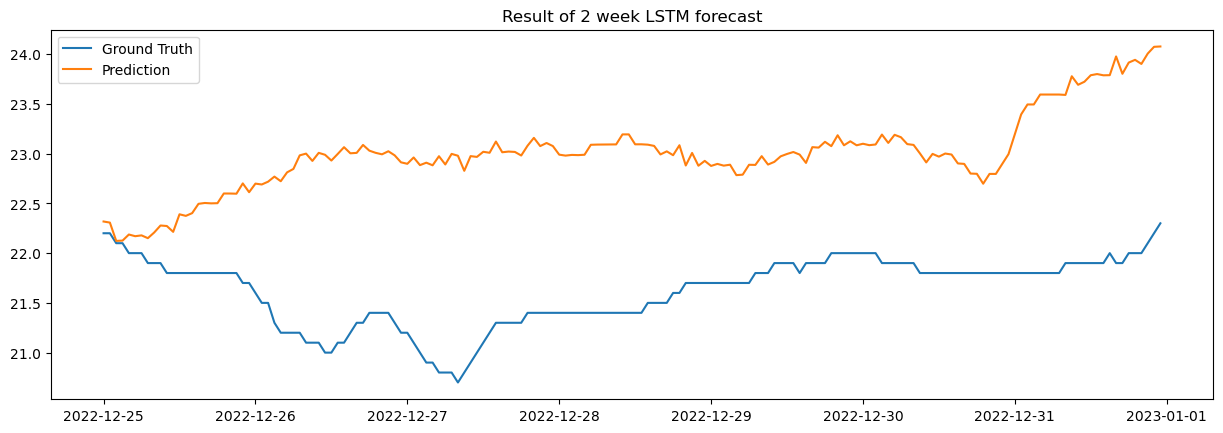

In [100]:
plt.figure().set_figwidth(15)
plt.plot(result["WTMP_42036"], label="Ground Truth")
plt.plot(result["Prediction"], label="Prediction")
plt.title("Result of 2 week LSTM forecast")
plt.legend()
plt.show()